In [1]:
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

In [2]:
plt.rcParams['figure.figsize'] = [12,8]
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)

In [3]:
def monthly_to_annual(array):
    """ calculate annual mena from monthly data, using unequal month lengths fros noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

def savgol_filter(array, window, order=2):
    smooth_array = array.copy()
    smooth_array[:] = scipy.signal.savgol_filter(array, window, order)
    return(smooth_array)


In [4]:
datadir = '/glade/scratch/charlie/archive/cesm_edriven_idealizedcdr_feb2022_v3'

lnd_in = xr.open_dataset(datadir+'/lnd/hist/cesm_edriven_idealizedcdr_feb2022_v3.clm2.sofar.nc')
ocn_in = xr.open_dataset(datadir+'/ocn/hist/cesm_edriven_idealizedcdr_feb2022_v3.pop.sofar.nc', decode_times=False)
atm_in = xr.open_dataset(datadir+'/atm/hist/cesm_edriven_idealizedcdr_feb2022_v3.cam.sofar.nc')

areacella = xr.open_dataset('/glade/scratch/charlie/cmip/areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
areacello = xr.open_dataset('/glade/scratch/charlie/cmip/areacello_Ofx_CESM2_1pctCO2_r1i1p1f1_gn.nc')

sftlf = xr.open_dataset('/glade/scratch/charlie/cmip/sftlf_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')
sftgif = xr.open_dataset('/glade/scratch/charlie/cmip/sftgif_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc')



/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)
/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding 

In [5]:
nyears = len(lnd_in['time'])/12.
print(nyears)

246.0


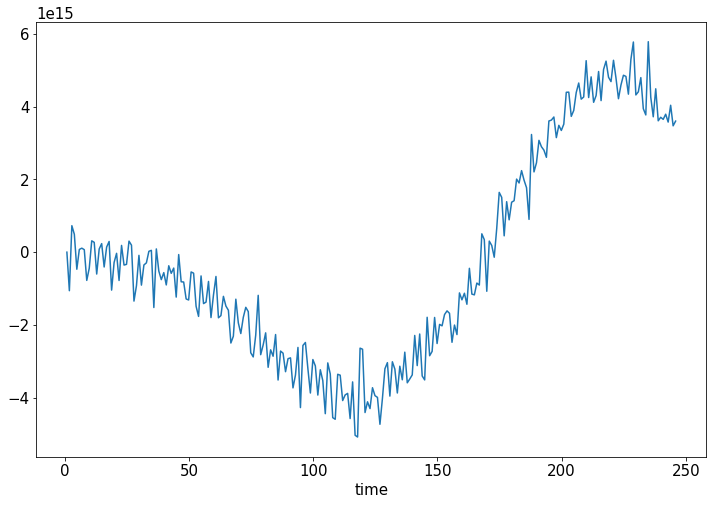

In [6]:
nbp_global = (lnd_in['NEE'] * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
nbp_global['time'] = np.arange(len(nbp_global['time']))/12.
nbp_annual = (monthly_to_annual(nbp_global)*86400. * 365.)
#nbp_annual.cumsum().plot()
nbp_annual.plot()

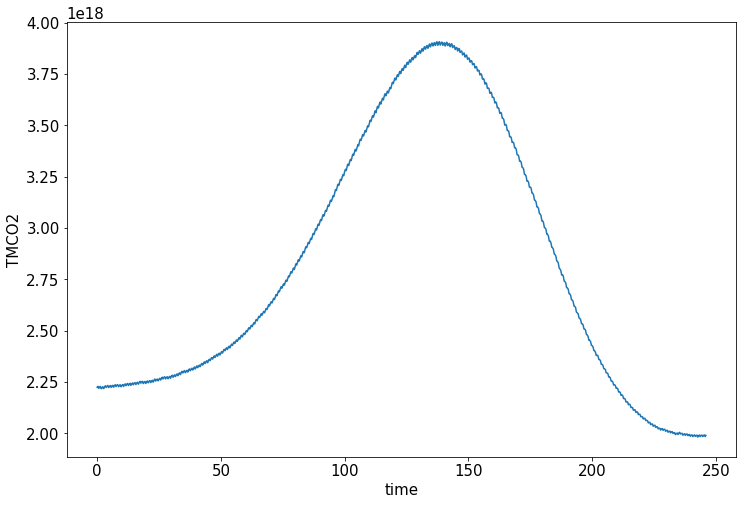

In [7]:
atmco2burden = (atm_in['TMCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) * 1e3
atmco2burden['time'] = np.arange(len(atmco2burden['time']))/12.
atmco2burden.plot()

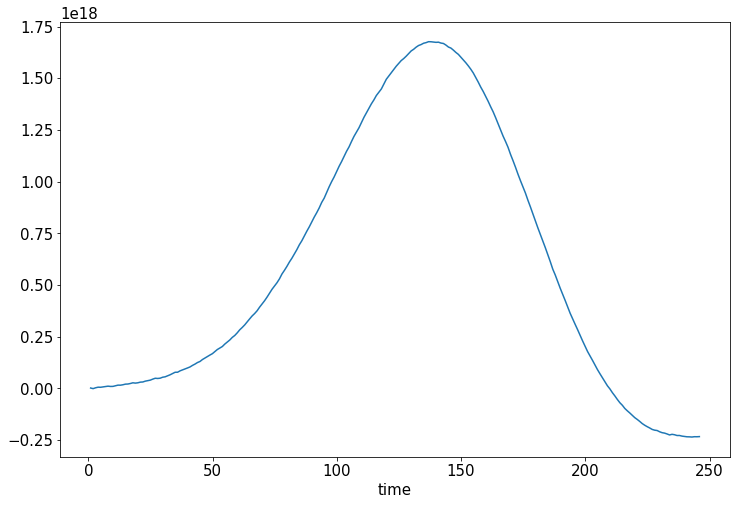

In [8]:
sfco2 = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))
sfco2['time'] = np.arange(len(sfco2['time']))/12.
sfco2_annual = monthly_to_annual(sfco2) * 86400. * 365. * 1e3 
sfco2_annual.cumsum().plot()

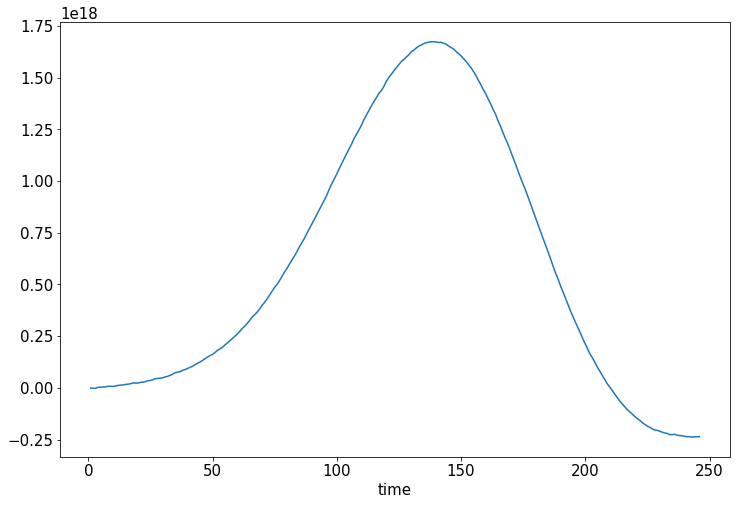

In [9]:
annual_atm_accum = monthly_to_annual(atmco2burden- atmco2burden[0])
annual_atm_accum.plot()

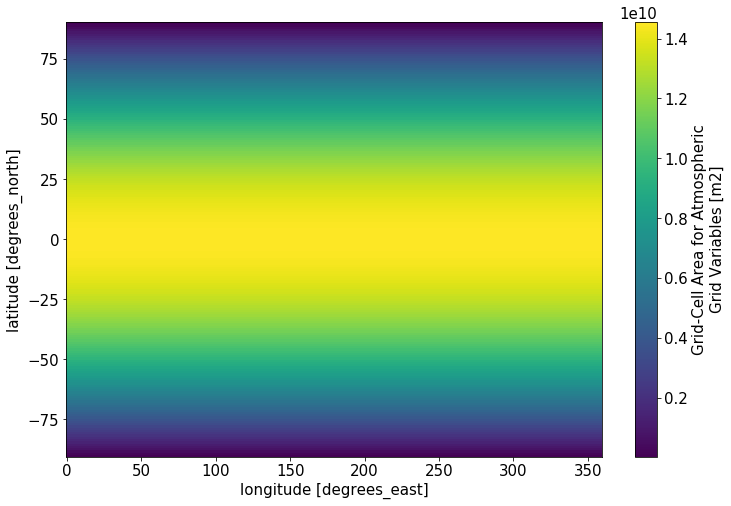

In [10]:
areacella['areacella'].plot()

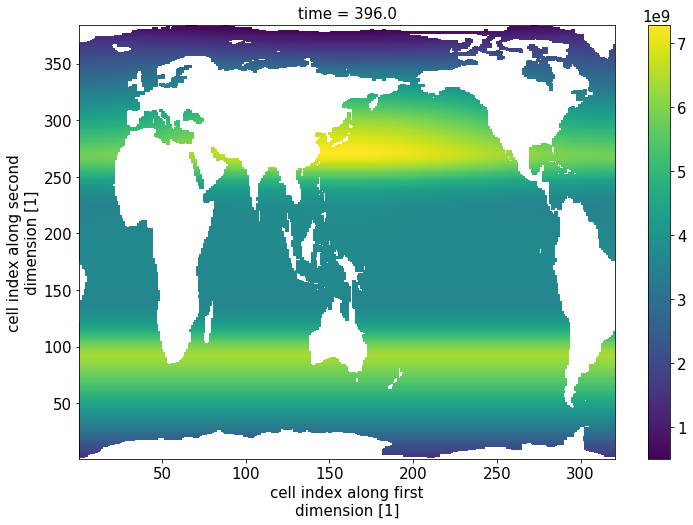

In [11]:
ocnmask = 1. * (ocn_in['SSH'].isel(time=0))/(ocn_in['SSH'].isel(time=0))
(areacello['areacello'] * ocnmask).plot()

/ncar/usr/jupyterhub/envs/pangeo-3.6/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


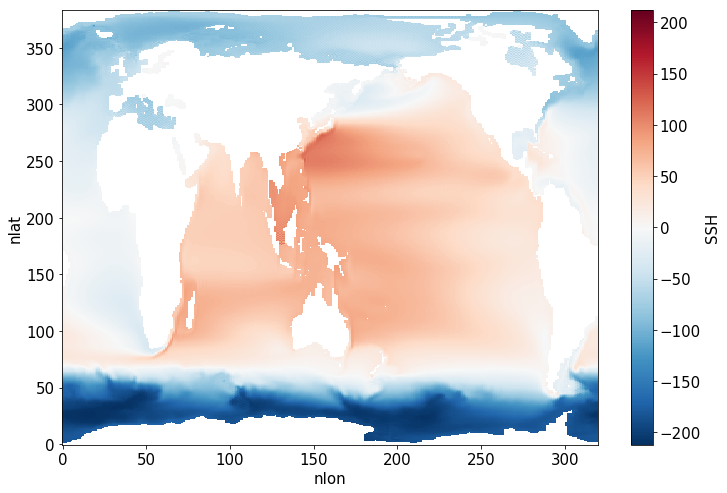

In [13]:
ocn_in['SSH'].mean(dim='time').plot()

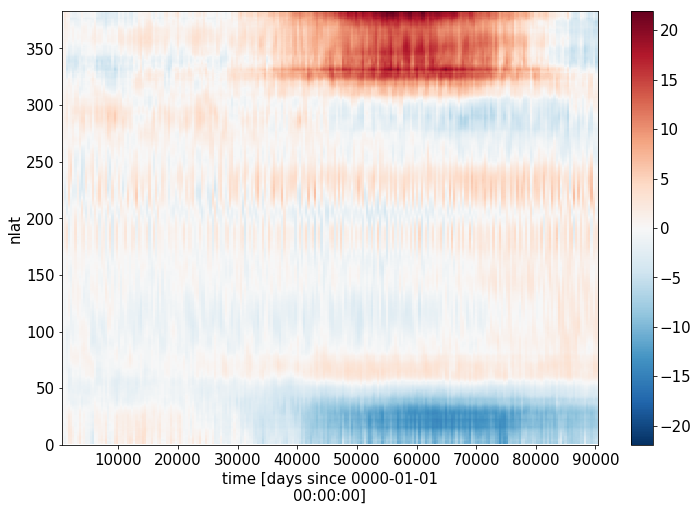

In [14]:
monthly_to_annual(ocn_in['SSH'].mean(dim='nlon') - ocn_in['SSH'].mean(dim='nlon').isel(time=slice(0,20)).mean(dim='time')).plot(y='nlat',x='time')

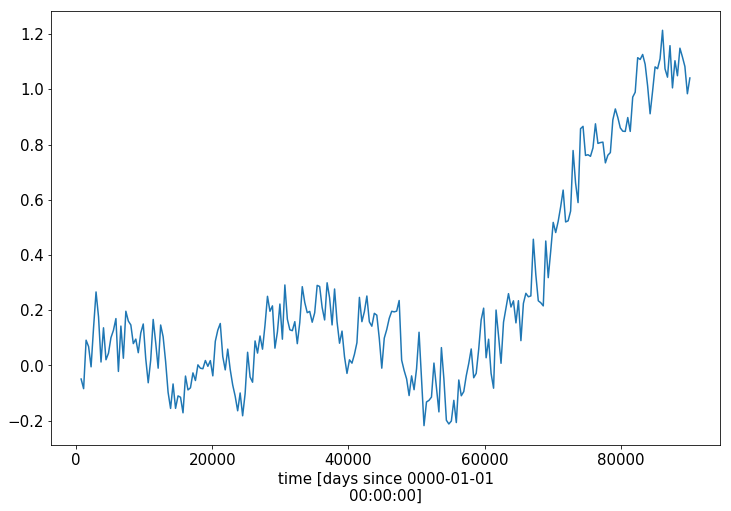

In [15]:
monthly_to_annual(ocn_in['SSH'].isel(nlat=slice(50,300)).mean(dim=('nlon','nlat')) - ocn_in['SSH'].isel(nlat=slice(50,300)).mean(dim=('nlon','nlat')).isel(time=slice(0,20)).mean(dim='time')).plot()

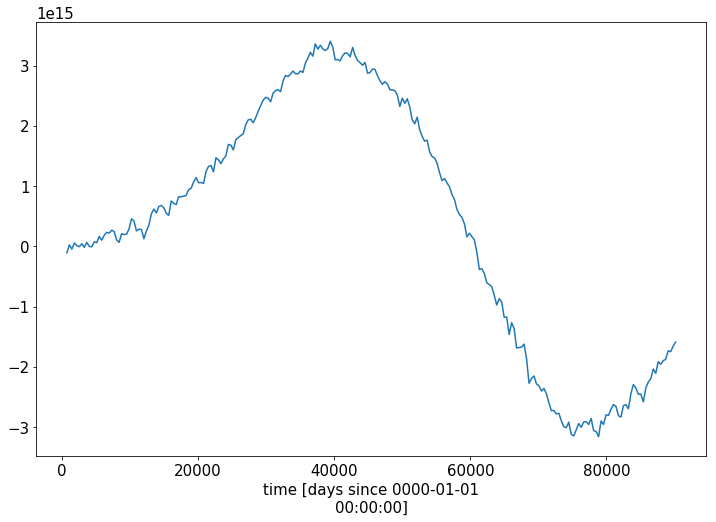

In [16]:
fgco2_global = (ocn_in['FG_CO2'] * areacello['areacello'].data * 12.0e-8 * 86400. * 365. * 1e3).sum(dim=('nlat', 'nlon'))
fgco2_global_annual = monthly_to_annual(fgco2_global)
fgco2_global_annual.plot()


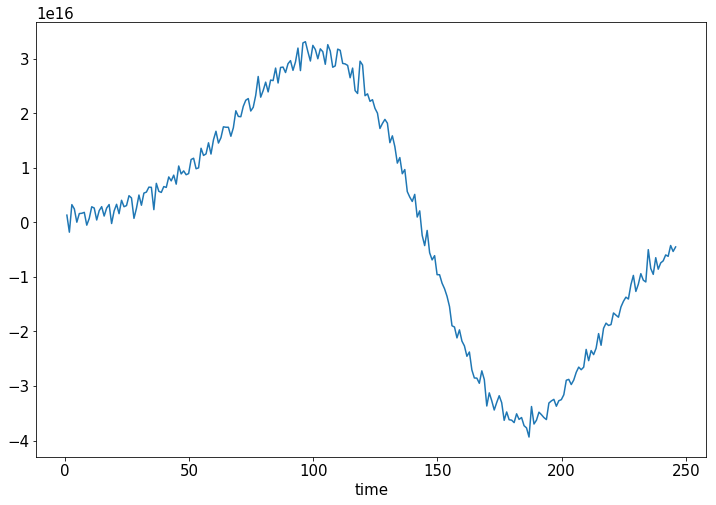

In [17]:
(fgco2_global_annual.data - nbp_annual.data + sfco2_annual).plot()

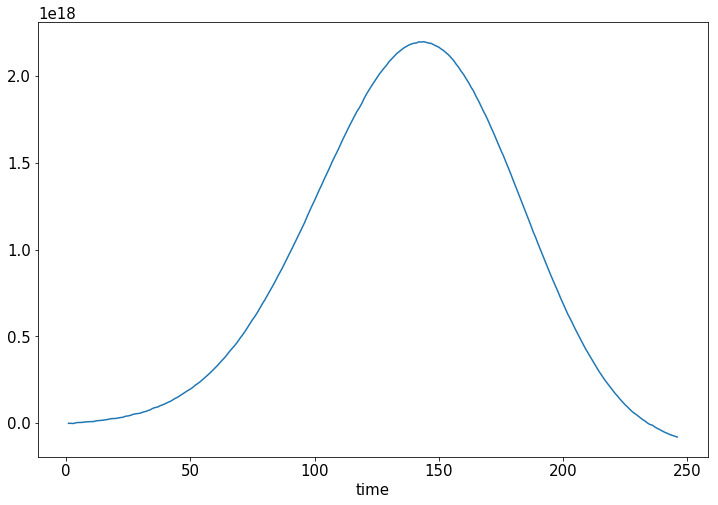

In [18]:
(fgco2_global_annual.cumsum().data - nbp_annual.cumsum().data + annual_atm_accum).plot()

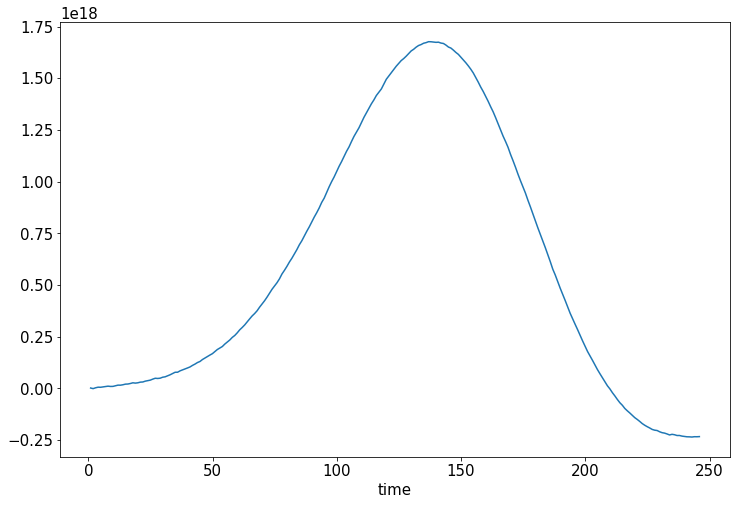

In [19]:
sfco2 = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))
sfco2['time'] = np.arange(len(sfco2['time']))/12.
sfco2_annual = monthly_to_annual(sfco2) * 86400. * 365. * 1e3 
sfco2_annual.cumsum().plot()

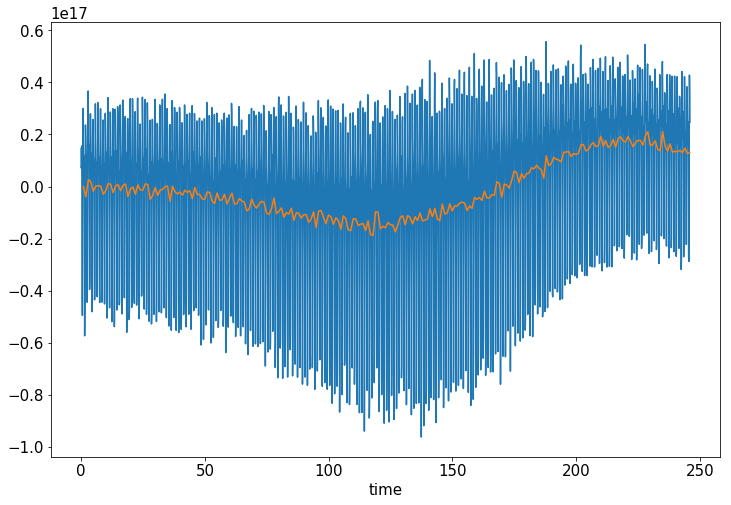

In [20]:
sfco2_lnd = (atm_in['SFCO2_LND'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_lnd['time'] = np.arange(len(sfco2_lnd['time']))/12.
sfco2_lnd_annual = monthly_to_annual(sfco2_lnd) 
sfco2_lnd.plot()
sfco2_lnd_annual.plot()

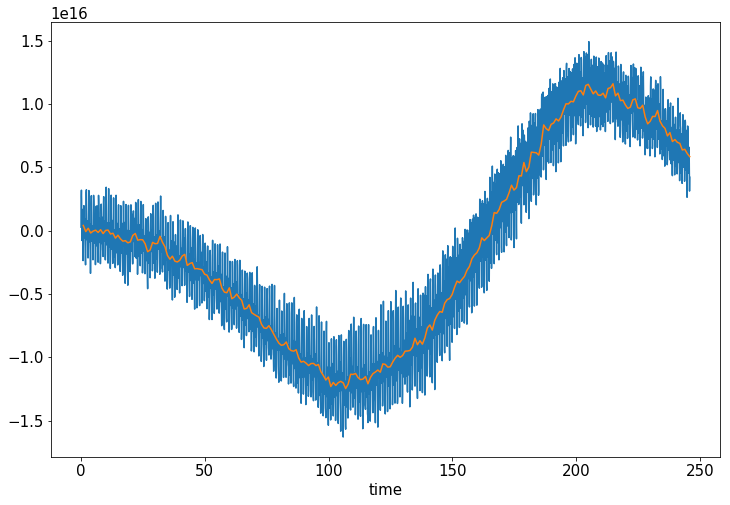

In [21]:
sfco2_ocn = (atm_in['SFCO2_OCN'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_ocn['time'] = np.arange(len(sfco2_ocn['time']))/12.
sfco2_ocn_annual = monthly_to_annual(sfco2_ocn) 
sfco2_ocn.plot()
sfco2_ocn_annual.plot()

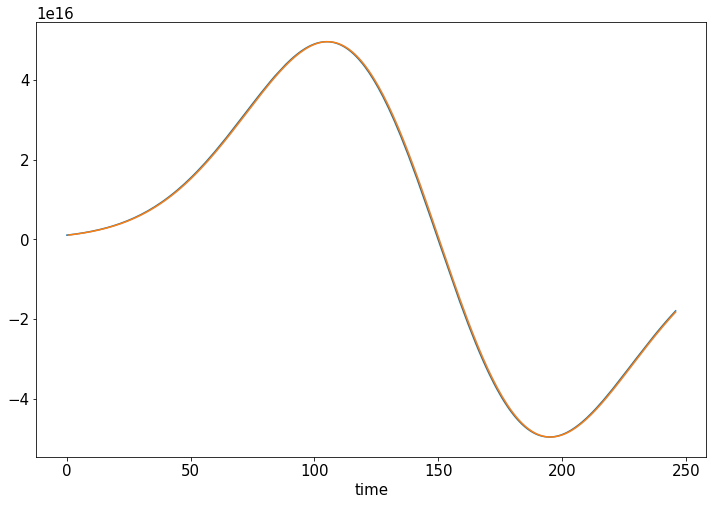

In [22]:
sfco2_fff = (atm_in['SFCO2_FFF'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_fff['time'] = np.arange(len(sfco2_fff['time']))/12.
sfco2_fff_annual = monthly_to_annual(sfco2_fff) 
sfco2_fff.plot()
sfco2_fff_annual.plot()

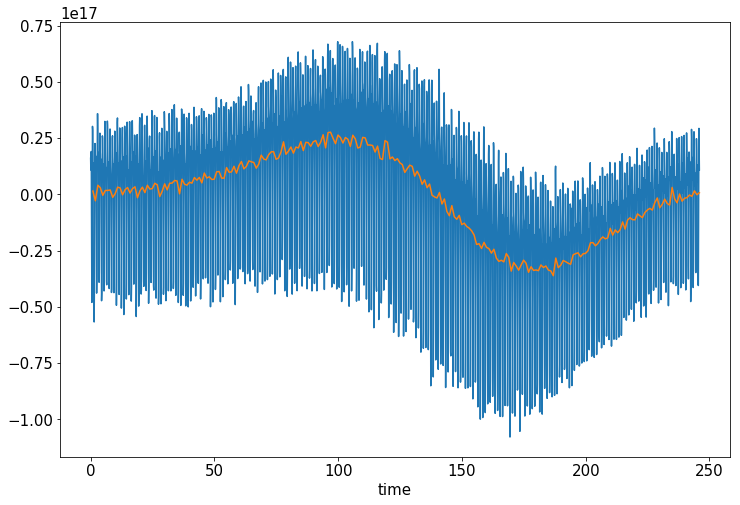

In [23]:
sfco2_tot = (atm_in['SFCO2'] * areacella['areacella'].data).sum(dim=('lat', 'lon'))* 86400. * 365. * 1e3 
sfco2_tot['time'] = np.arange(len(sfco2_tot['time']))/12.
sfco2_tot_annual = monthly_to_annual(sfco2_tot) 
sfco2_tot.plot()
sfco2_tot_annual.plot()

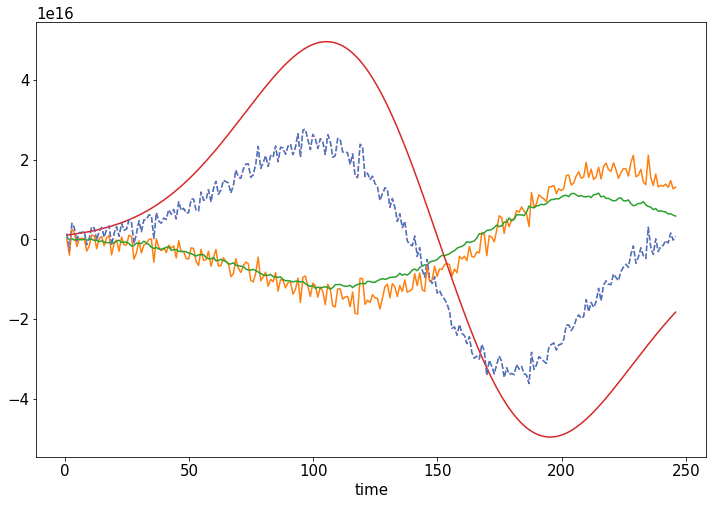

In [24]:
sfco2_tot_annual.plot(linestyle='--')
sfco2_lnd_annual.plot()
sfco2_ocn_annual.plot()
sfco2_fff_annual.plot()
(sfco2_lnd_annual + sfco2_ocn_annual + sfco2_fff_annual).plot(linestyle='dotted')

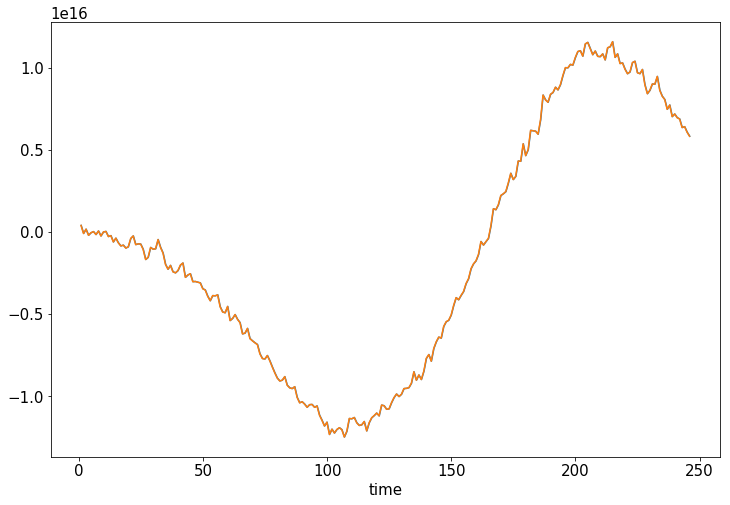

In [25]:
fgco2_global_annual['time'] = np.arange(len(fgco2_global_annual['time']))+1.
(0.-fgco2_global_annual * 44./12.).plot()
sfco2_ocn_annual.plot()

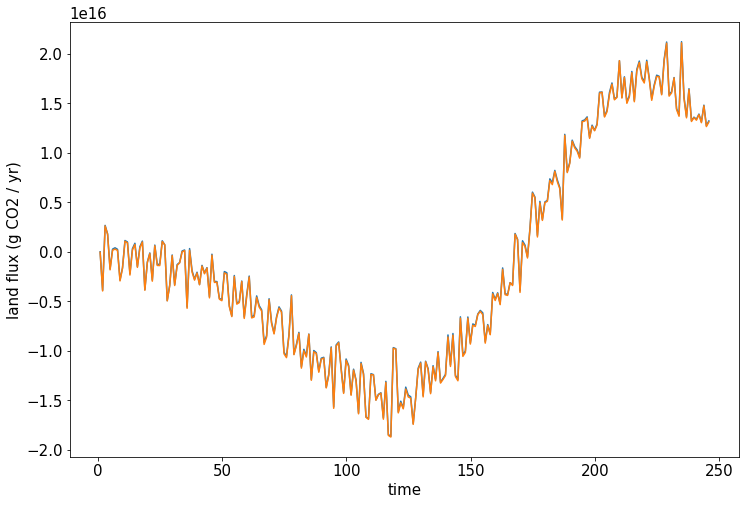

In [26]:
(nbp_annual*44./12.).plot()
sfco2_lnd_annual.attrs['long_name'] = 'land flux (g CO2 / yr)'
sfco2_lnd_annual.plot()


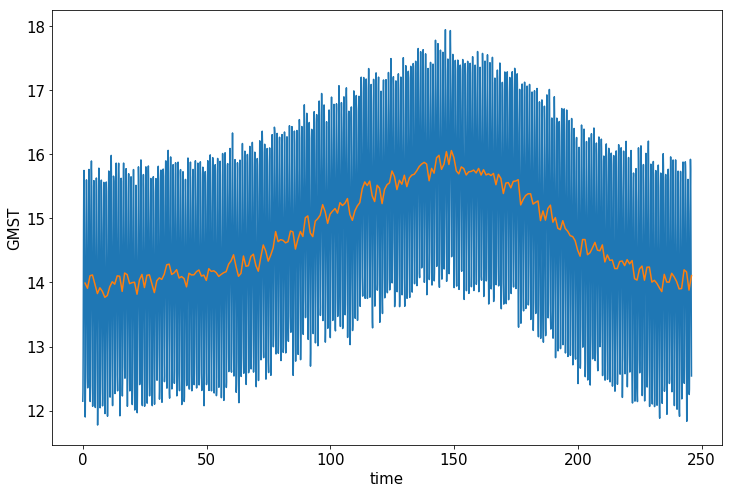

In [27]:
gmst =  -273.15 +(atm_in['TREFHT'] * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
gmst['time'] = np.arange(len(gmst['time']))/12.
gmst_annual = monthly_to_annual(gmst)
gmst_annual.attrs['long_name'] = 'GMST'
gmst.attrs['long_name'] = 'GMST'
gmst.plot()
gmst_annual.plot()

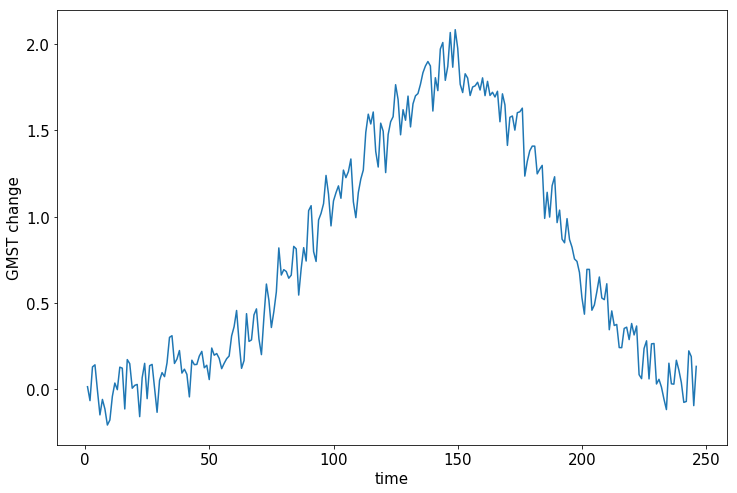

In [28]:
annual_gmst_difference = (gmst_annual - gmst_annual[0:20].mean(dim='time'))
annual_gmst_difference.attrs['long_name'] = 'GMST change'
annual_gmst_difference.plot()

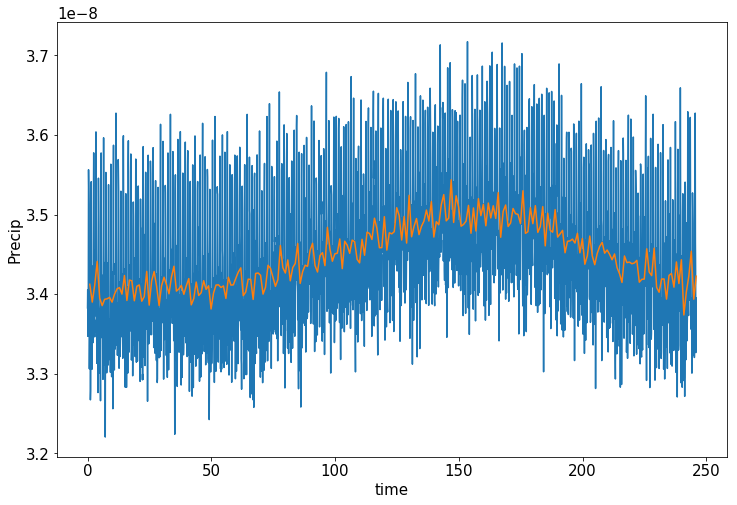

In [29]:
precip =  ((atm_in['PRECC'] + atm_in['PRECL']) * areacella['areacella'].data).sum(dim=('lat', 'lon')) / areacella['areacella'].sum(dim=('lat', 'lon'))
precip['time'] = np.arange(len(precip['time']))/12.
precip_annual = monthly_to_annual(precip)
precip_annual.attrs['long_name'] = 'Precip'
precip.attrs['long_name'] = 'Precip'
precip.plot()
precip_annual.plot()

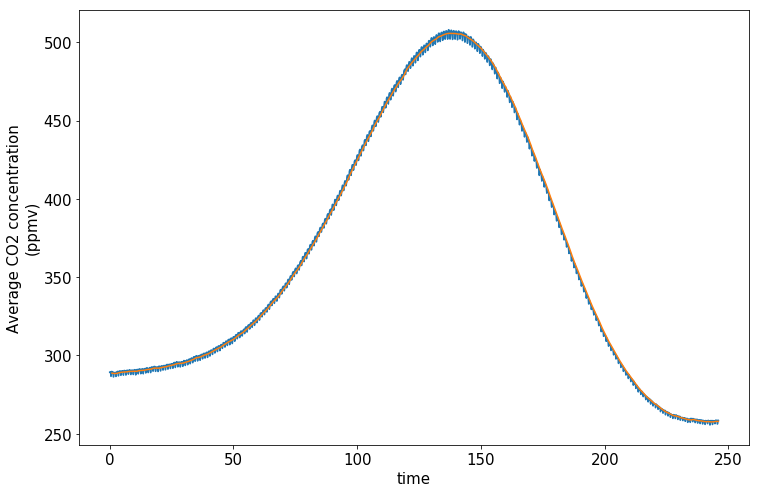

In [30]:
lnd_co2_ppmv = (lnd_in['PCO2']/lnd_in['PBOT']).mean(dim=('lat', 'lon')) * 1e6
lnd_co2_ppmv['time'] = np.arange(len(lnd_co2_ppmv['time']))/12.
lnd_co2_ppmv_annual = monthly_to_annual(lnd_co2_ppmv)
lnd_co2_ppmv.attrs['long_name'] = 'Average CO2 concentration (ppmv)'
lnd_co2_ppmv_annual.attrs['long_name'] = 'Average CO2 concentration (ppmv)'
lnd_co2_ppmv.plot()
lnd_co2_ppmv_annual.plot()

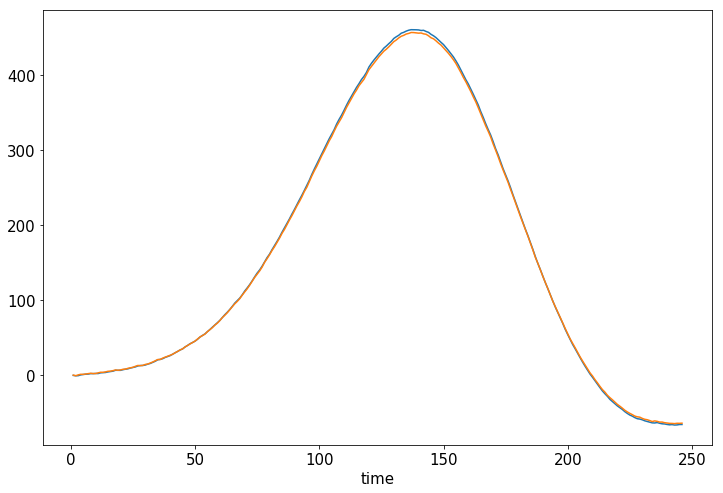

In [31]:
ppm_to_pgc = 2.124

atm_co2_pgc = ppm_to_pgc *(lnd_co2_ppmv_annual - lnd_co2_ppmv_annual[0])

atm_co2_pgc.plot()

((1e-15 * 12./44.)*sfco2_tot_annual).cumsum().plot()

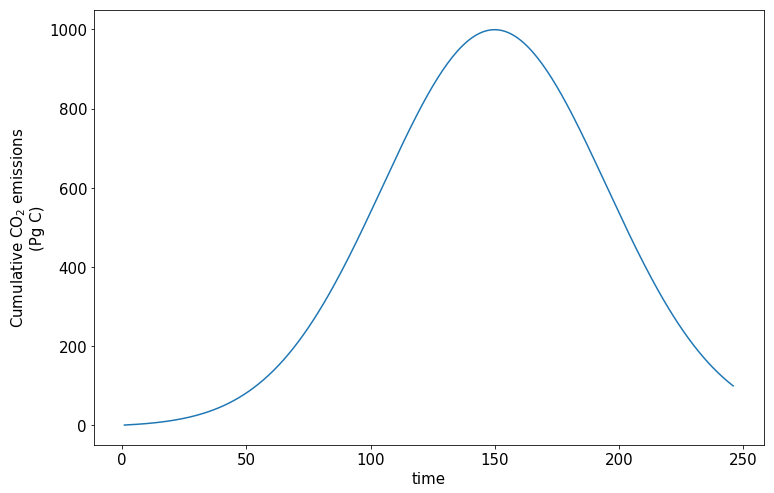

In [32]:
cumulative_emissions_pgc = ((1e-15*12./44.)*sfco2_fff_annual).cumsum()
cumulative_emissions_pgc.attrs['long_name'] = 'Cumulative CO$_2$ emissions (Pg C)'
cumulative_emissions_pgc.plot()

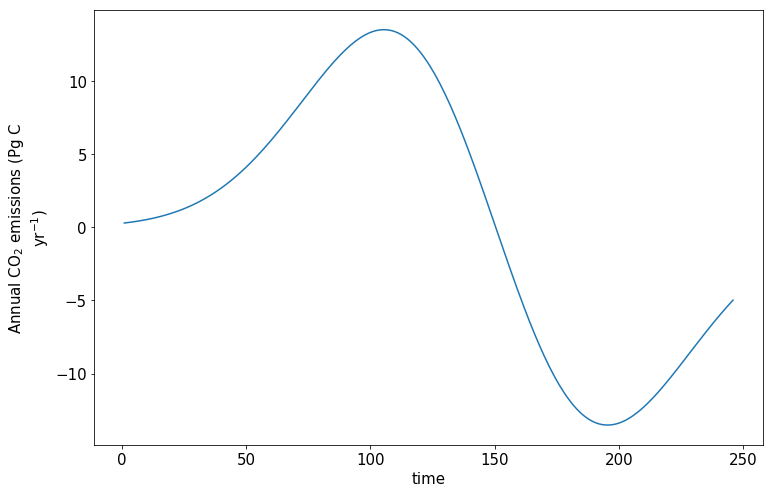

In [33]:
annual_emmissions_pgc = ((1e-15*12./44.)*sfco2_fff_annual)
annual_emmissions_pgc.attrs['long_name'] = 'Annual CO$_2$ emissions (Pg C yr$^{-1}$)'
annual_emmissions_pgc.plot()

TCRE =  2.079529412181452


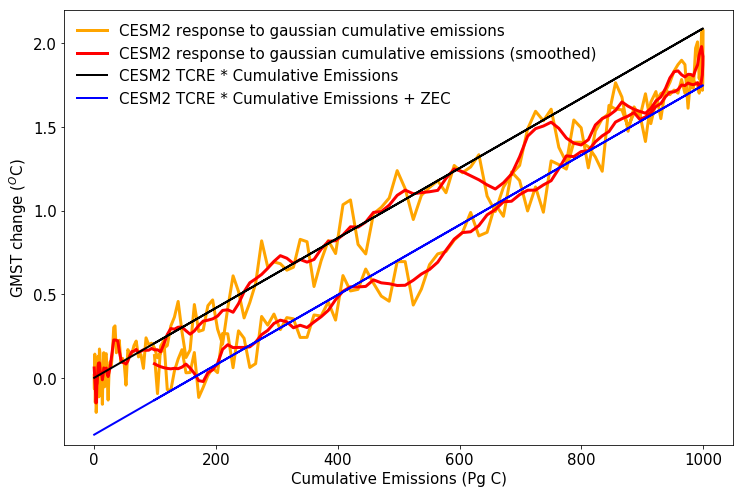

In [34]:
plt.plot(cumulative_emissions_pgc, annual_gmst_difference, color='Orange', label='CESM2 response to gaussian cumulative emissions', linewidth=3)

plt.plot(cumulative_emissions_pgc, savgol_filter(annual_gmst_difference, 11), color='Red', label='CESM2 response to gaussian cumulative emissions (smoothed)', linewidth=3)


m, b = np.polyfit(cumulative_emissions_pgc[0:int(annual_emmissions_pgc.argmax())], annual_gmst_difference[0:int(annual_emmissions_pgc.argmax())], 1)
#plt.plot(cumulative_emissions_pgc, m*cumulative_emissions_pgc + b)

tcre_arora = 2.09 * 1e-3
zec90_macdougall = -0.34

plt.plot(cumulative_emissions_pgc, tcre_arora*cumulative_emissions_pgc, color='Black', label='CESM2 TCRE * Cumulative Emissions', linewidth=2)
plt.plot(cumulative_emissions_pgc, tcre_arora*cumulative_emissions_pgc + zec90_macdougall, color='Blue', label='CESM2 TCRE * Cumulative Emissions + ZEC', linewidth=2)


plt.ylabel('GMST change ($^O$C)')
plt.xlabel('Cumulative Emissions (Pg C)')

plt.legend(frameon=False)

plt.ylim((-0.4,2.2))

print('TCRE = ', m * 1000.)


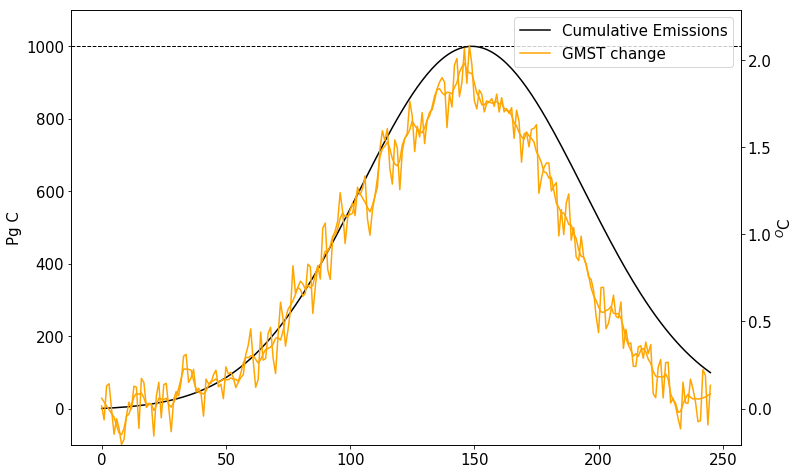

In [35]:
ax1 = plt.subplot()
l1, = ax1.plot(cumulative_emissions_pgc, color='black')
ax2 = ax1.twinx()
l2, = ax2.plot(annual_gmst_difference, color='orange')

ax1.set_ylim((-100,1100))
ax1.set_ylabel('Pg C')

ax2.set_ylim((-100. * m, 1100. * m))
ax2.set_ylabel('$^O$C')

ax1.axhline(1000., color='black', linestyle='--', linewidth=1)

ax2.plot(savgol_filter(annual_gmst_difference, 11), color='orange')



plt.legend([l1, l2], ["Cumulative Emissions", "GMST change"])

plt.show()

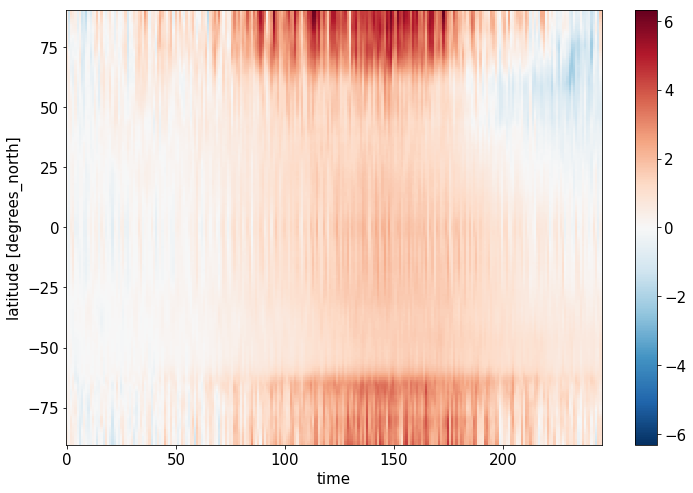

In [36]:
zonal_mean_temp = monthly_to_annual(atm_in['TREFHT'] - 273.15).mean(dim='lon')
zonal_mean_temp['time'] = np.arange(len(zonal_mean_temp['time']))
zonal_mean_temp_diff = zonal_mean_temp - zonal_mean_temp.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_temp_diff.plot(x='time',y='lat')

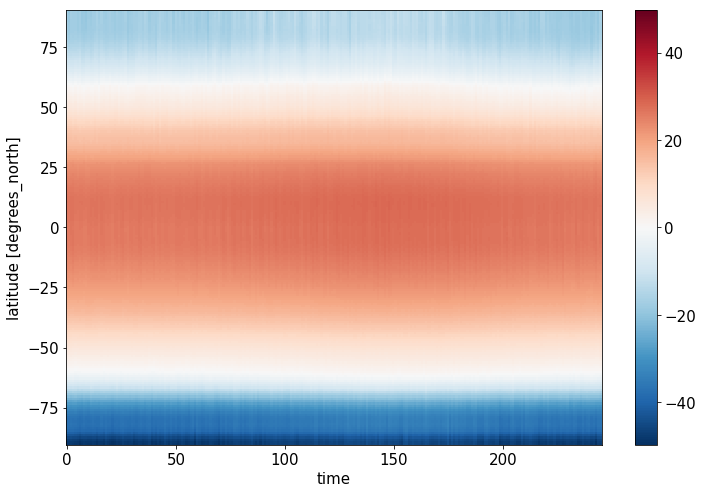

In [37]:
zonal_mean_temp.plot(x='time',y='lat')

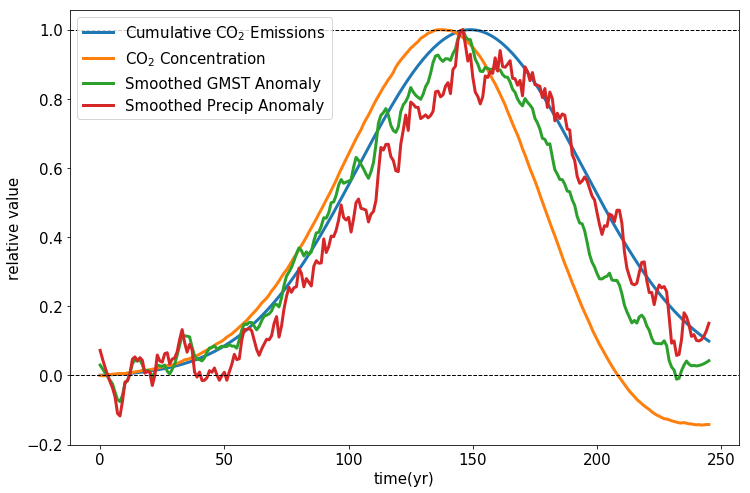

In [38]:
smoothing_window = 11

plt.plot(cumulative_emissions_pgc/cumulative_emissions_pgc.max(), label='Cumulative CO$_2$ Emissions', linewidth=3)
plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration', linewidth=3)
plt.plot(savgol_filter(annual_gmst_difference, smoothing_window)/savgol_filter(annual_gmst_difference, smoothing_window).max(), label='Smoothed GMST Anomaly', linewidth=3)
plt.plot(savgol_filter((precip_annual - precip_annual.isel(time=slice(0,20)).mean(dim='time')), smoothing_window)/savgol_filter((precip_annual - precip_annual.isel(time=slice(0,20)).mean(dim='time')), smoothing_window).max(), label='Smoothed Precip Anomaly', linewidth=3)
plt.axhline(0., color='black', linestyle='--', linewidth=1)
plt.axhline(1., color='black', linestyle='--', linewidth=1)
plt.xlabel('time(yr)')
plt.ylabel('relative value')
plt.legend()

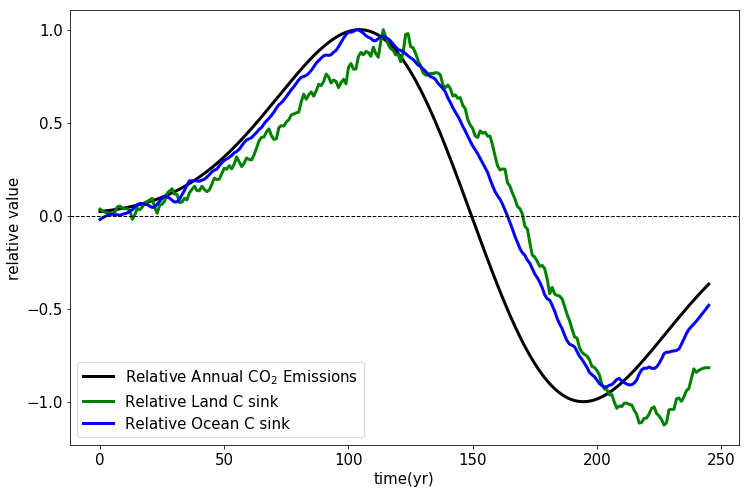

In [39]:

plt.plot(annual_emmissions_pgc/annual_emmissions_pgc.max(), label='Relative Annual CO$_2$ Emissions', linewidth=3, color='Black')
plt.plot(savgol_filter(-1. * sfco2_lnd_annual, smoothing_window)/savgol_filter(-1. * sfco2_lnd_annual, smoothing_window).max(), label = 'Relative Land C sink', linewidth=3, color='Green')
plt.plot(savgol_filter(-1. * sfco2_ocn_annual, smoothing_window)/savgol_filter(-1. * sfco2_ocn_annual, smoothing_window).max(), label = 'Relative Ocean C sink', linewidth=3, color='Blue')
plt.axhline(0., color='black', linestyle='--', linewidth=1)
plt.xlabel('time(yr)')
plt.ylabel('relative value')
plt.legend()

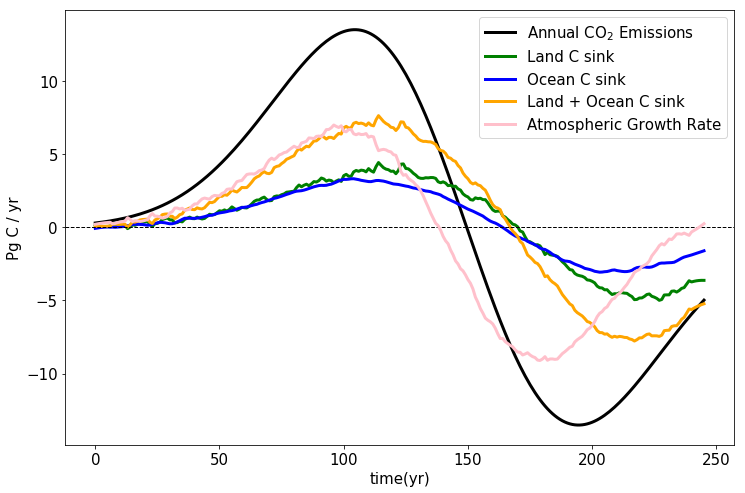

In [51]:

plt.plot(annual_emmissions_pgc, label='Annual CO$_2$ Emissions', linewidth=3, color='Black')
plt.plot(savgol_filter(12./44. * 1e-15 * -1. * sfco2_lnd_annual, smoothing_window), label = 'Land C sink', linewidth=3, color='Green')
plt.plot(savgol_filter(12./44. * 1e-15 * -1. * sfco2_ocn_annual, smoothing_window), label = 'Ocean C sink', linewidth=3, color='Blue')
plt.plot(savgol_filter(12./44. * 1e-15 * -1. * (sfco2_ocn_annual+sfco2_lnd_annual), smoothing_window), label = 'Land + Ocean C sink', linewidth=3, color='Orange')
plt.axhline(0., color='black', linestyle='--', linewidth=1)

atm_growth_rate = annual_emmissions_pgc - savgol_filter(12./44. * 1e-15 * -1. * (sfco2_ocn_annual+sfco2_lnd_annual), smoothing_window)
plt.plot(atm_growth_rate, label = 'Atmospheric Growth Rate', linewidth=3, color='Pink')

plt.xlabel('time(yr)')
plt.ylabel('Pg C / yr')
plt.legend()

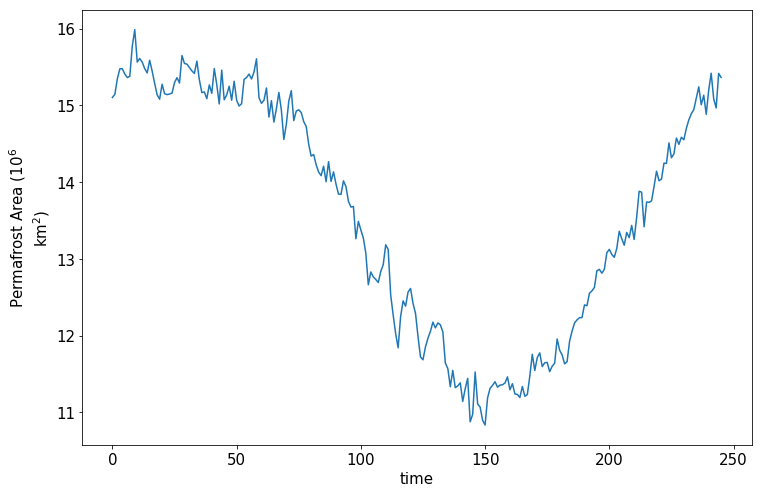

In [41]:
permafrost_area = 1e-12 *((lnd_in['ALTMAX'][::12,:,:] < 3.) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
#permafrost_area.shape
permafrost_area['time'] = np.arange(len(permafrost_area['time']))
permafrost_area.attrs['long_name'] = 'Permafrost Area (10$^6$ km$^2$)'
permafrost_area.plot()

In [42]:
pf = lnd_in['ALTMAX'][0:240:12,:,:].mean(dim='time') < 3.
#pf.plot()

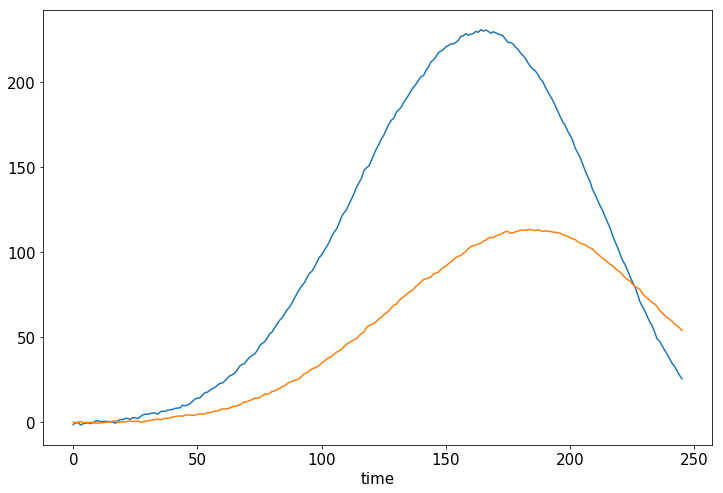

In [43]:
vegc = 1e-15 * (monthly_to_annual(lnd_in['TOTVEGC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
vegc['time'] = np.arange(len(vegc['time']))

totsomc = 1e-15 * (monthly_to_annual(lnd_in['TOTSOMC_1m'] + lnd_in['TOTLITC'] + lnd_in['CWDC']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
totsomc['time'] = np.arange(len(totsomc['time']))

pf_soilc = 1e-15 * (monthly_to_annual(lnd_in['TOTSOMC']) * pf * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
pf_soilc['time'] = np.arange(len(pf_soilc['time']))


(vegc - vegc.isel(time=slice(0,20)).mean(dim='time')).plot()
(totsomc - totsomc.isel(time=slice(0,20)).mean(dim='time')).plot()
#totsomc.plot()
#pf_soilc.plot()

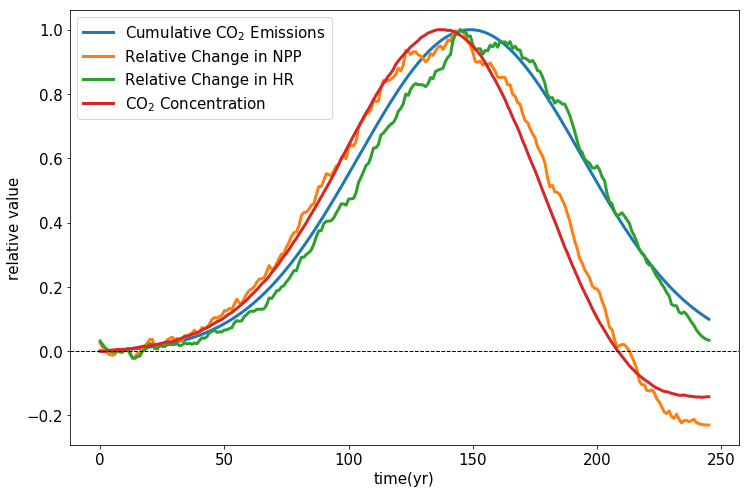

In [44]:
gpp = 1e-15 * 86400. * 365. * (monthly_to_annual(lnd_in['GPP']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
gpp['time'] = np.arange(len(gpp['time']))

npp = 1e-15 * 86400. * 365. * (monthly_to_annual(lnd_in['NPP']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
npp['time'] = np.arange(len(npp['time']))

hr = 1e-15 * 86400. * 365. * (monthly_to_annual(lnd_in['HR']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
hr['time'] = np.arange(len(hr['time']))

burnflux = 1e-15 * 86400. * 365. * (monthly_to_annual(lnd_in['COL_FIRE_CLOSS']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
burnflux['time'] = np.arange(len(burnflux['time']))


gpp_anom = savgol_filter(gpp - gpp.isel(time=slice(0,20)).mean(dim='time'), smoothing_window)
npp_anom = savgol_filter(npp - npp.isel(time=slice(0,20)).mean(dim='time'), smoothing_window)
hr_anom = savgol_filter(hr - hr.isel(time=slice(0,20)).mean(dim='time'), smoothing_window)


plt.plot(cumulative_emissions_pgc/cumulative_emissions_pgc.max(), label='Cumulative CO$_2$ Emissions', linewidth=3)

#(gpp_anom/gpp_anom.max()).plot(label='Relative Change in GPP', linewidth=3)
(npp_anom/npp_anom.max()).plot(label='Relative Change in NPP', linewidth=3)
(hr_anom/hr_anom.max()).plot(label='Relative Change in HR', linewidth=3)
plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration', linewidth=3)

plt.axhline(0., color='black', linestyle='--', linewidth=1)

plt.xlabel('time(yr)')
plt.ylabel('relative value')
plt.legend()

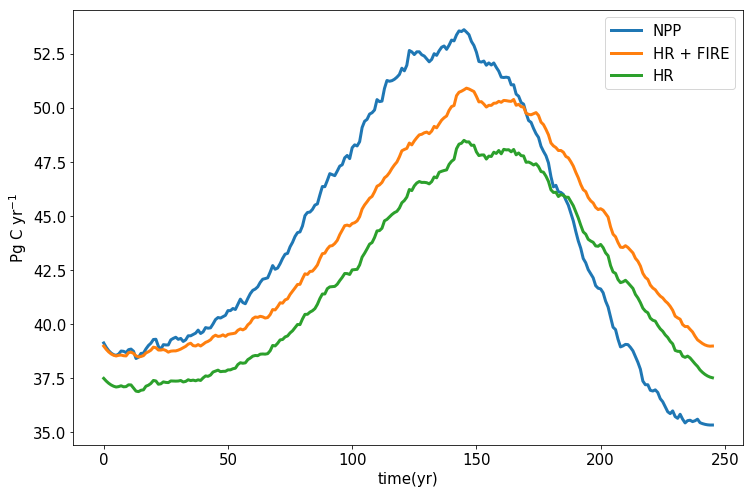

In [45]:

#plt.plot(cumulative_emissions_pgc/cumulative_emissions_pgc.max(), label='Cumulative CO$_2$ Emissions', linewidth=3)

#(gpp_anom/gpp_anom.max()).plot(label='Relative Change in GPP', linewidth=3)
savgol_filter(npp, smoothing_window).plot(label='NPP', linewidth=3)
#npp_smooth = npp.copy()
#npp_smooth[:] = scipy.signal.savgol_filter(npp, smoothing_window, 2)
#npp_smooth.plot(label='NPP smooth', linewidth=1)
savgol_filter(hr+burnflux, smoothing_window).plot(label='HR + FIRE', linewidth=3)
savgol_filter(hr, smoothing_window).plot(label='HR', linewidth=3)
#plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration', linewidth=3)


plt.xlabel('time(yr)')
plt.ylabel('Pg C yr$^{-1}$')
plt.legend()

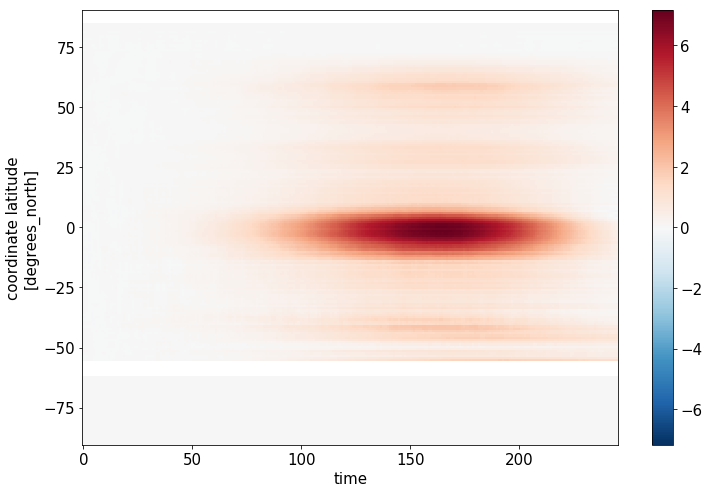

In [46]:
zonal_mean_totvegc = monthly_to_annual(lnd_in['TOTVEGC']).mean(dim='lon') * 1e-3
zonal_mean_totvegc['time'] = np.arange(len(zonal_mean_totvegc['time']))
zonal_mean_totvegc_diff = zonal_mean_totvegc - zonal_mean_totvegc.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_totvegc_diff.plot(x='time',y='lat')

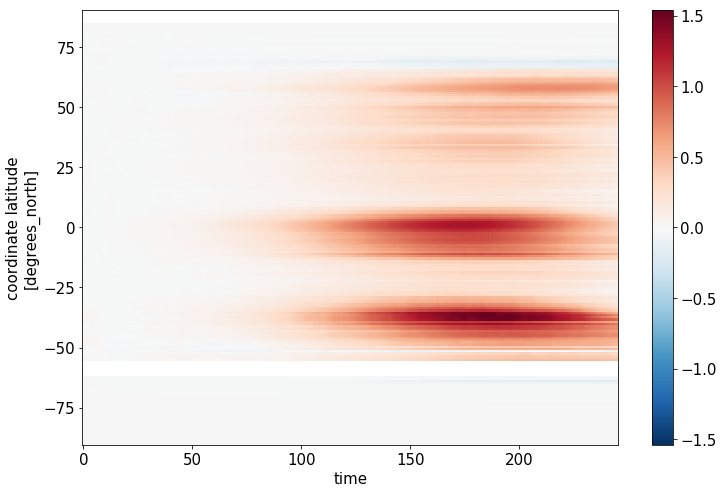

In [47]:
zonal_mean_totsomc = monthly_to_annual(lnd_in['TOTSOMC']).mean(dim='lon') * 1e-3
zonal_mean_totsomc['time'] = np.arange(len(zonal_mean_totvegc['time']))
zonal_mean_totsomc_diff = zonal_mean_totsomc - zonal_mean_totsomc.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_totsomc_diff.plot(x='time',y='lat')

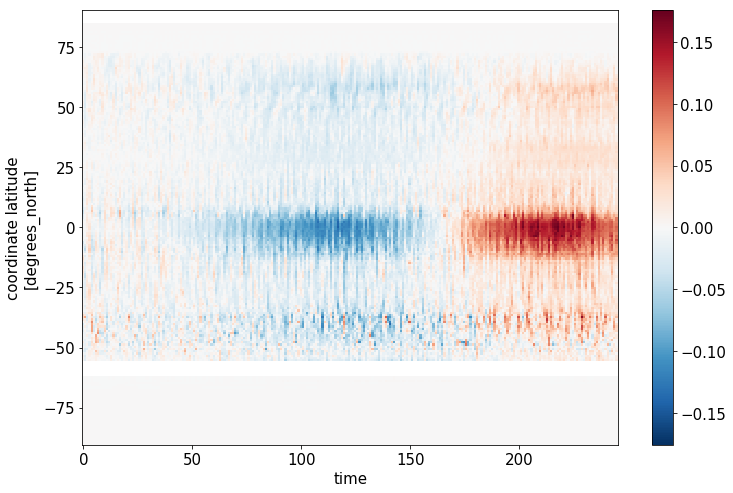

In [48]:
zonal_mean_nee = monthly_to_annual(lnd_in['NEE']).mean(dim='lon') * 1e-3 * 86400. * 365.
zonal_mean_nee['time'] = np.arange(len(zonal_mean_totvegc['time']))
zonal_mean_nee_diff = zonal_mean_nee - zonal_mean_nee.isel(time=slice(0,20)).mean(dim='time')
zonal_mean_nee_diff.plot(x='time',y='lat')

In [49]:
int(annual_emmissions_pgc.argmax())

104

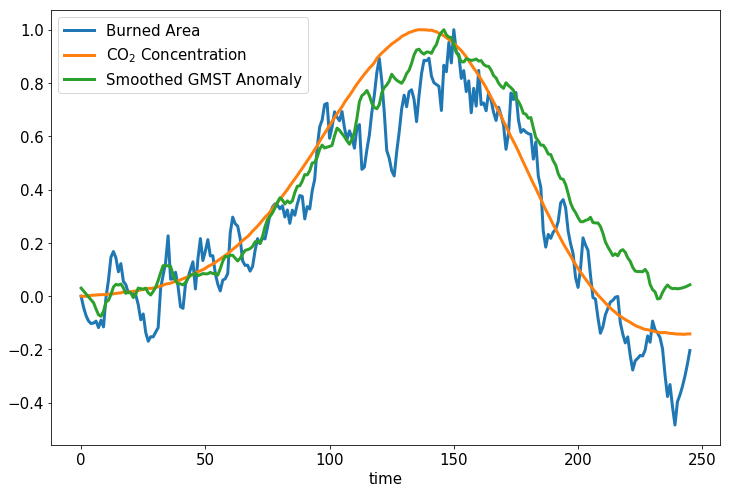

In [50]:


burnedarea = 86400. * 365. * (monthly_to_annual(lnd_in['FAREA_BURNED']) * areacella['areacella'].data * sftlf['sftlf'].data/100. * (1. - sftgif['sftgif'].data/100.)).sum(dim=('lat', 'lon'))
burnedarea['time'] = np.arange(len(burnedarea['time']))

burnedarea_smooth = savgol_filter(burnedarea, smoothing_window)
#burnedarea.plot()
((burnedarea_smooth - burnedarea_smooth.isel(time=slice(0,20)).mean())/(burnedarea_smooth - burnedarea_smooth.isel(time=slice(0,20)).mean()).max()).plot(label='Burned Area', linewidth=3)

plt.plot(atm_co2_pgc/atm_co2_pgc.max(), label='CO$_2$ Concentration', linewidth=3)
plt.plot(savgol_filter(annual_gmst_difference, smoothing_window)/savgol_filter(annual_gmst_difference, smoothing_window).max(), label='Smoothed GMST Anomaly', linewidth=3)

plt.legend()

